In [1]:
# import os
# import subprocess

# # Get the parent of the parent directory
# target_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# # The repo URL
# repo_url = "https://huggingface.co/datasets/cordutie/MicroTex"

# # Run the clone command
# subprocess.run(["git", "clone", repo_url], cwd=target_dir)

In [2]:
# Add the parent directory to the Python path
import sys
import os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import loss function
from texstat.functions import *
from texstat.fad import *
from texstat.segmentation import *
import texstat.torch_filterbanks.filterbanks as fb

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import time
import gc
from tabulate import tabulate  # For creating tables

# Pick device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Multiscale Spectrogram Loss for comparison
def multiscale_fft(signal, scales=[4096, 2048, 1024, 512, 256, 128], overlap=.75):
    stfts = []
    for s in scales:
        S = torch.stft(
            signal,
            s,
            int(s * (1 - overlap)),
            s,
            torch.hann_window(s).to(signal),
            True,
            normalized=True,
            return_complex=True,
        ).abs()
        stfts.append(S)
    return stfts

def safe_log(x):
    return torch.log(x + 1e-7)

def multiscale_spectrogram_loss(x, x_hat):
    ori_stft = multiscale_fft(x)
    rec_stft = multiscale_fft(x_hat)
    loss = 0
    for s_x, s_y in zip(ori_stft, rec_stft):
        lin_loss = (s_x - s_y).abs().mean()
        log_loss = (safe_log(s_x) - safe_log(s_y)).abs().mean()
        loss = loss + lin_loss + log_loss
    return loss

Found 10 files in ../../MicroTex/freesound_class
    Segmented 38 segments from ../../MicroTex/freesound_class/keyboard/keyboard_ceramic.wav
    Segmented 183 segments from ../../MicroTex/freesound_class/keyboard/keyboard_mechanic.wav
    Segmented 27 segments from ../../MicroTex/freesound_class/keyboard/keyboard_yellow.wav
    Segmented 191 segments from ../../MicroTex/freesound_class/water/water_augmented_2.wav
    Segmented 48 segments from ../../MicroTex/freesound_class/water/water.wav
    Segmented 44 segments from ../../MicroTex/freesound_class/wind/wind_interior.wav
    Segmented 191 segments from ../../MicroTex/freesound_class/fire/fire_augmented.wav
    Segmented 123 segments from ../../MicroTex/freesound_class/rain/rain.wav
    Segmented 59 segments from ../../MicroTex/freesound_class/bubbles/bubbles_short_extended.wav
    Segmented 242 segments from ../../MicroTex/freesound_class/bubbles/bubbles_long.wav
Total segments: 1146
Processing noise level: 0.1
Processing noise level

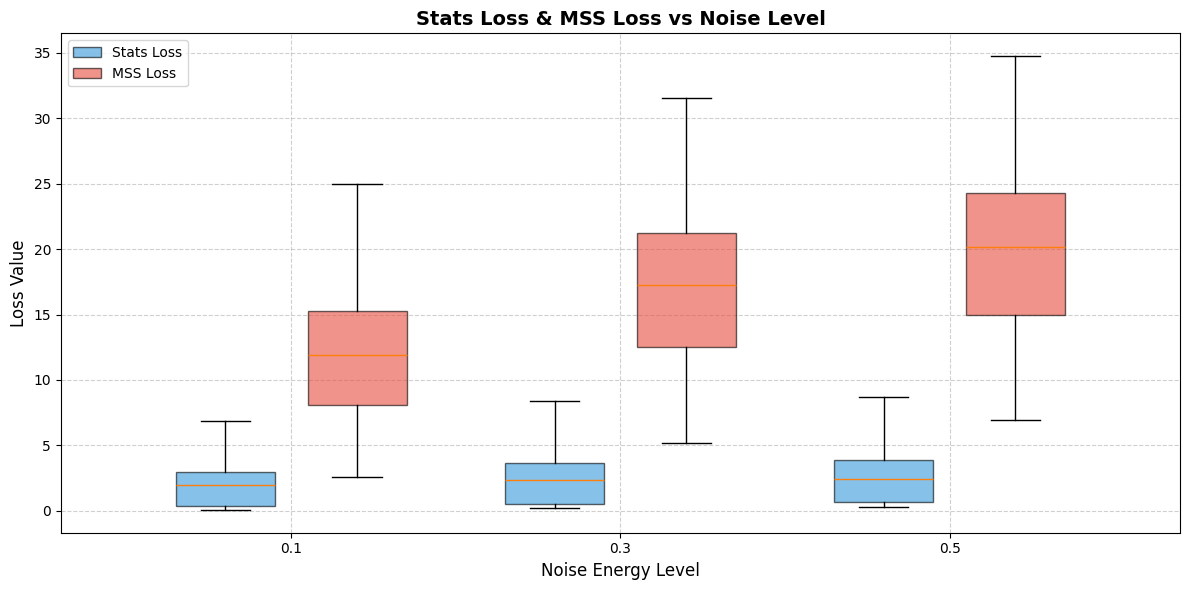

In [4]:
def experiment_noise(data_path, sr=44100, frame_size=44000, experiment_size = "Full"):
    if experiment_size == "Full":
        segments_number = None
    else:
        segments_number = experiment_size

    # Device selection
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # TexStat parameters
    N_filter_bank = 16
    M_filter_bank = 6
    N_moments     = 4
    alpha         = torch.tensor([10, 1, 1/10, 1/100], device=device)
    beta          = torch.tensor([1, 1, 1, 1, 1], device=device) 
    new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
    downsampler = torchaudio.transforms.Resample(sr, new_sr).to(device)
    coch_fb     = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    mod_fb      = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

    segments_batch = segmentate_from_path(data_path, sampling_rate = sr, segment_length = frame_size, segments_number = segments_number, torch_type=False)
    segments_batch = torch.tensor(segments_batch, dtype=torch.float32, device=device)
    segments_batch = segments_batch / torch.max(torch.abs(segments_batch), dim=1, keepdim=True)[0]

    if experiment_size == "Full":
        experiment_size = segments_batch.shape[0]

    # Create a batch of 100 random noise segments
    noise_batch = torch.randn(experiment_size, frame_size, device=device)
    noise_batch = noise_batch / torch.max(torch.abs(noise_batch), dim=1, keepdim=True)[0]  # Normalize to [-1, 1]

    # Store losses for boxplot
    stats_losses = []
    mss_losses   = []
    noise_levels = [0.1, 0.3, 0.5]

    stats_mean_std = []  # Store mean ± std for table
    mss_mean_std = []

    for energy in noise_levels:
        print(f"Processing noise level: {energy:.1f}")
        stats_loss_i = []
        mss_loss_i = []
        segments_noisy = segments_batch + energy * noise_batch

        for i in range(experiment_size):
            segment_local       = segments_batch[i]
            segment_noisy_local = segments_noisy[i]

            stats_loss_local = texstat_loss(segment_local, segment_noisy_local, coch_fb, mod_fb, downsampler, N_moments, alpha, beta)
            # detect if there is a NaN in the loss and skip this segment
            if torch.isnan(stats_loss_local).any():
                print(f"NaN detected in stats loss for segment {i}, skipping...")
                continue
            mss_loss_local = multiscale_spectrogram_loss(segment_local, segment_noisy_local)

            stats_loss_i.append(stats_loss_local.item())  # Convert to scalar
            mss_loss_i.append(mss_loss_local.item())

        stats_losses.append(stats_loss_i)
        mss_losses.append(mss_loss_i)

        # Calculate mean and std for each noise level
        stats_mean_std.append(f"{np.mean(stats_loss_i):.4f} ± {np.std(stats_loss_i):.4f}")
        mss_mean_std.append(f"{np.mean(mss_loss_i):.4f} ± {np.std(mss_loss_i):.4f}")

    # Create side-by-side boxplots **without outliers**
    plt.figure(figsize=(12, 6))

    # Boxplot for stats loss (no fliers)
    box1 = plt.boxplot(stats_losses, positions=np.arange(len(noise_levels)) - 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#3498db", alpha=0.6),
                        showfliers=False)  # Removes outliers

    # Boxplot for MSS loss (no fliers)
    box2 = plt.boxplot(mss_losses, positions=np.arange(len(noise_levels)) + 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#e74c3c", alpha=0.6),
                        showfliers=False)  # Removes outliers

    # Labels and styling
    plt.xticks(range(len(noise_levels)), [f"{lvl:.1f}" for lvl in noise_levels])
    plt.xlabel("Noise Energy Level", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.title("Stats Loss & MSS Loss vs Noise Level", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Add legend manually
    plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Stats Loss", "MSS Loss"], loc="upper left")

    # Create table of mean ± std values
    table_data = []
    for i, noise_level in enumerate(noise_levels):
        table_data.append([f"{noise_level:.1f}", stats_mean_std[i], mss_mean_std[i]])

    # Display the table
    table_header = ["Noise Level", "Stats Loss (mean ± std)", "MSS Loss (mean ± std)"]
    table_str = tabulate(table_data, headers=table_header, tablefmt="grid", floatfmt=".4f")

    print(table_str)

    # Show plot
    plt.tight_layout()
    plt.show()

# experiment_noise("../../MicroTex/boreillysegmented16K_class", sr=44100, frame_size=44099)
experiment_noise("../../MicroTex/freesound_class",            sr=44100, frame_size=44099)
# experiment_noise("../../MicroTex/syntex_class",               sr=44100, frame_size=44099)

Found 10 files in ../../MicroTex/freesound_class
    Segmented 38 segments from ../../MicroTex/freesound_class/keyboard/keyboard_ceramic.wav
    Segmented 183 segments from ../../MicroTex/freesound_class/keyboard/keyboard_mechanic.wav
    Segmented 27 segments from ../../MicroTex/freesound_class/keyboard/keyboard_yellow.wav
    Segmented 191 segments from ../../MicroTex/freesound_class/water/water_augmented_2.wav
    Segmented 48 segments from ../../MicroTex/freesound_class/water/water.wav
    Segmented 44 segments from ../../MicroTex/freesound_class/wind/wind_interior.wav
    Segmented 191 segments from ../../MicroTex/freesound_class/fire/fire_augmented.wav
    Segmented 123 segments from ../../MicroTex/freesound_class/rain/rain.wav
    Segmented 59 segments from ../../MicroTex/freesound_class/bubbles/bubbles_short_extended.wav
    Segmented 242 segments from ../../MicroTex/freesound_class/bubbles/bubbles_long.wav
Total segments: 1146
+---------------------------------------+---------

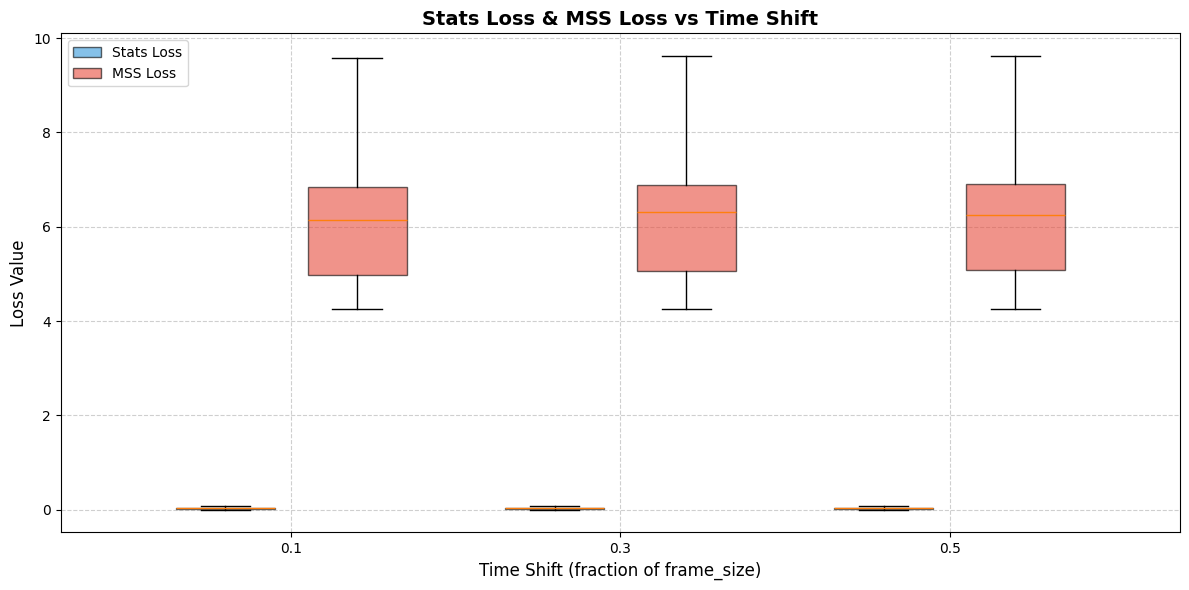

In [8]:
# Assuming texstat_loss and multiscale_spectrogram_loss are defined elsewhere
def experiment_time_shift(data_path,  sr=44100, frame_size=44000, experiment_size = "Full"):
    if experiment_size == "Full":
        segments_number = None
    else:
        segments_number = experiment_size
    # Device selection
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # TexStat parameters
    N_filter_bank = 16
    M_filter_bank = 6
    N_moments     = 4
    alpha         = torch.tensor([10, 1, 1/10, 1/100], device=device)
    beta          = torch.tensor([1, 1, 1, 1, 1], device=device) 
    new_sr, new_frame_size = sr // 4, frame_size // 4 # for downsampler
    downsampler = torchaudio.transforms.Resample(sr, new_sr).to(device)
    coch_fb     = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    mod_fb      = fb.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

    segments_batch = segmentate_from_path(data_path, sampling_rate = sr, segment_length = frame_size, segments_number = segments_number, torch_type=False)
    segments_batch = torch.tensor(segments_batch, dtype=torch.float32, device=device)

    experiment_size = segments_batch.shape[0] if experiment_size == "Full" else experiment_size

    # Store losses for boxplot
    stats_losses = []
    mss_losses = []
    shift_levels = [0.1, 0.3, 0.5]  # Shift steps
    shift_levels = [int(shift * frame_size) for shift in shift_levels]  # Convert to samples
    stats_mean_std = []
    mss_mean_std = []

    for shift in shift_levels:
        stats_loss_i = []
        mss_loss_i = []
        segments_shifted = torch.roll(segments_batch, shifts=shift, dims=1)  # Shift in time

        for i in range(experiment_size):
            segment_local = segments_batch[i]
            segment_shifted_local = segments_shifted[i]

            stats_loss_local = texstat_loss(segment_local, segment_shifted_local, coch_fb, mod_fb, downsampler, N_moments, alpha, beta)
            mss_loss_local   = multiscale_spectrogram_loss(segment_local, segment_shifted_local)

            stats_loss_i.append(stats_loss_local.item())
            mss_loss_i.append(mss_loss_local.item())

        stats_losses.append(stats_loss_i)
        mss_losses.append(mss_loss_i)

        # Calculate mean and std for each shift level
        stats_mean_std.append(f"{np.mean(stats_loss_i):.4f} ± {np.std(stats_loss_i):.4f}")
        mss_mean_std.append(f"{np.mean(mss_loss_i):.4f} ± {np.std(mss_loss_i):.4f}")

    # Create side-by-side boxplots **without outliers**
    plt.figure(figsize=(12, 6))

    # Boxplot for stats loss (no fliers)
    box1 = plt.boxplot(stats_losses, positions=np.arange(len(shift_levels)) - 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#3498db", alpha=0.6),
                        showfliers=False)

    # Boxplot for MSS loss (no fliers)
    box2 = plt.boxplot(mss_losses, positions=np.arange(len(shift_levels)) + 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#e74c3c", alpha=0.6),
                        showfliers=False)

    # Labels and styling
    plt.xticks(range(len(shift_levels)), [f"{shift/frame_size:.1f}" for shift in shift_levels])
    plt.xlabel("Time Shift (fraction of frame_size)", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.title("Stats Loss & MSS Loss vs Time Shift", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Add legend manually
    plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Stats Loss", "MSS Loss"], loc="upper left")

    # Show boxplots
    plt.tight_layout()

    # Create table of mean ± std values
    table_data = []
    for i, shift in enumerate(shift_levels):
        table_data.append([f"{shift/frame_size:.1f}", stats_mean_std[i], mss_mean_std[i]])

    # Display the table
    table_header = ["Time Shift (fraction of frame_size)", "Stats Loss (mean ± std)", "MSS Loss (mean ± std)"]
    table_str = tabulate(table_data, headers=table_header, tablefmt="grid", floatfmt=".4f")

    print(table_str)

    # Show plot
    plt.show()

# experiment_time_shift("../../MicroTex/boreillysegmented16K_class", sr=44100, frame_size=44099)
experiment_time_shift("../../MicroTex/freesound_class",            sr=44100, frame_size=44099)
# experiment_time_shift("../../MicroTex/syntex_class",               sr=44100, frame_size=44099)